# Classification Task on R8 corpus with Frequent Subgraphs

## Goal of this Notebook

The goal of this notebook is to demonstrate the usage of frequent subgraphs for a multi-class classification task  implemented in the [gowpy library](https://github.com/GuillaumeDD/gowpy) and applied on the R8 dataset. 

Frequent subgraphs corresponding to long range n-gram can be mined and subsequently used for document classification [1]. Classification with frequent subgraphs happens in a 3-step process:

1. Conversion of the corpus of already preprocessed documents into a collection of graph-of-words
1. Mining the frequent subgraphs
1. Loading the frequent subgraphs and exploiting them for classification


Long story short: 
- the usage of frequent subgraphs shows interesting performance on this dataset ; 
- however, performance results are a bit under what is obtained via a standard TF-IDF model w.r.t.  accuracy, F1 (macro, micro) and MCC metrics ; and 
- usage of frequent subgraphs is computation-intensive.

The R8 dataset is the preprocessed Reuters dataset with the top 8 classes. It contains 5,495 training documents and 2,189 testing documents, with 8 different labels. Preprocessing involves: tokenization, stop-words removal and stemming to the initial texts. The version of the dataset comes from this [github repository](https://github.com/Nath-B/Graph-Of-Words).

[1] [Text Categorization as a Graph Classification Problem](http://www.aclweb.org/anthology/P15-1164).
      *Rousseau, François, Kiagias, Emmanouil and Vazirgiannis, Michalis*.
      *Proceedings of the 53rd Annual Meeting of the Association for Computational Linguistics and the 7th International 
      Joint Conference on Natural Language Processing* (**ACL 2015**)

## Python Environment

Preparation of the python environment:
```bash
pip install gowpy pandas
```

In [1]:
import pandas as pd

%matplotlib inline

In [2]:
from gowpy.feature_extraction.gow import GoWVectorizer
from gowpy.gow.miner import GoWMiner
from gowpy.gow.io import gow_to_data

## Loading the dataset

In [3]:
df_train = pd.read_csv('datasets/r8/r8-train-stemmed.txt',
                        header = None, 
                        sep='\t', 
                        names = ['label', 'document'])
X_train = df_train['document']
y_train = df_train['label']

X_train[0], y_train[0]

('champion product approv stock split champion product inc board director approv two for stock split common share for sharehold record april compani board vote recommend sharehold annual meet april increas author capit stock mln mln share reuter',
 'earn')

In [4]:
y_train.value_counts()

earn        2840
acq         1596
crude        253
trade        251
money-fx     206
interest     190
ship         108
grain         41
Name: label, dtype: int64

In [5]:
df_test = pd.read_csv('datasets/r8/r8-test-stemmed.txt',
                        header = None, 
                        sep='\t', 
                        names = ['label', 'document'])
X_test = df_test['document']
y_test = df_test['label']

y_test.value_counts()

earn        1083
acq          696
crude        121
money-fx      87
interest      81
trade         75
ship          36
grain         10
Name: label, dtype: int64

## Frequent Subgraphs Mining

Frequent subgraphs mining is perform on a "per label" basis.

From [1] :
> In standard  binary graph  classification (e.  g.,  pre-dicting chemical
compounds’ carcinogenicity aseither positive  or negative (Helma et al.,
2001)), feature mining  is performed on  the whole graph collection  as we
expect  the mined  features to  be able to  discriminate between  the two
classes (thusproducing a good classifier).  However, for the task of text
categorization,  there are  usually more than  two classes  (e.  g.,  118
categories of  news articles  for the  Reuters-21578 dataset)  and with
a skewed  class   distribution  (e.  g.,   a  lot  more   news related  to
“acquisition”  than to  “grain”).   Therefore, a  single support  value
might lead  to some classes generating  a tremendous number  of features
(e.g., hundreds  of thousands of frequent subgraphs)  and some others
only  a few  (e.  g., a  few hundreds subgraphs)  resulting  in a  skewed
and non-discriminative feature set.   To include discriminative features
for  these minority classes,   we would  need  an  extremely   low  support
resulting in    an    exponential     number    of    features    because
of the majority classes.  For  these reasons, we decided  to mine frequent
subgraphs  per  class  using the  same  relative  support  (%)  and  then
aggregating  each   feature  set  into   a  global  one  at   the  cost
of a supervised process (but  which still avoids  cross-validated parameter
tuning).

### Splitting the multi-class corpus

In [6]:
from collections import defaultdict

label_to_documents = defaultdict(list)

for label, document in zip(y_train, X_train):
    label_to_documents[label].append(document)
    
label_to_documents = dict(label_to_documents)

for label, documents in label_to_documents.items():
    print(f'Label "{label}": {len(list(documents))} documents')

Label "earn": 2840 documents
Label "acq": 1596 documents
Label "trade": 251 documents
Label "ship": 108 documents
Label "grain": 41 documents
Label "crude": 253 documents
Label "interest": 190 documents
Label "money-fx": 206 documents


### Corpus to gow

In [7]:
gow_miner = GoWMiner()

In [8]:
label_to_gows = {}

for label, documents in label_to_documents.items():
    gows = gow_miner.compute_gow_from_corpus(documents)
    label_to_gows[label] = gows

In [9]:
gow_miner

Graph-of-word miner:
        - is_directed: False
        - is_weighted: False
        - window_size: 4
        - edge_labeling: True

        - Number of tokens: 14575
        - Number of links between tokens: 376354

        - Number of loaded subgraph: 0
        

### Export gow du corpus

In [10]:
SUPPORT = "0.096"

filename_prefixes_output = []

for label, gows in label_to_gows.items():
    gows = label_to_gows[label]
    data = gow_to_data(gows)
    
    filename_input = f"train-r8-gows-{label}.data"
    filename_prefix_output = f"gbolt-mining-train-r8-{label}"
    # Saving the filenames for the loading step of the subgraphs
    filename_prefixes_output.append(filename_prefix_output)
    
    with open(filename_input, "w") as f_output:
        f_output.write(data)
        
    print(f"OMP_NUM_THREADS=1 gbolt --input {filename_input} --output {filename_prefix_output} --dfs --nodes --support {SUPPORT}")

OMP_NUM_THREADS=1 gbolt --input train-r8-gows-earn.data --output gbolt-mining-train-r8-earn --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-acq.data --output gbolt-mining-train-r8-acq --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-trade.data --output gbolt-mining-train-r8-trade --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-ship.data --output gbolt-mining-train-r8-ship --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-grain.data --output gbolt-mining-train-r8-grain --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-crude.data --output gbolt-mining-train-r8-crude --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-interest.data --output gbolt-mining-train-r8-interest --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-money-fx.data --output gbolt-mining-train-r8-money-fx --dfs --nodes --support 0.096


### Mining

Mining can be performed via the `gBolt` software (C++) : https://github.com/Jokeren/gBolt :

```sh
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-earn.data --output gbolt-mining-train-r8-earn --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-acq.data --output gbolt-mining-train-r8-acq --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-trade.data --output gbolt-mining-train-r8-trade --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-ship.data --output gbolt-mining-train-r8-ship --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-grain.data --output gbolt-mining-train-r8-grain --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-crude.data --output gbolt-mining-train-r8-crude --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-interest.data --output gbolt-mining-train-r8-interest --dfs --nodes --support 0.096
OMP_NUM_THREADS=1 gbolt --input train-r8-gows-money-fx.data --output gbolt-mining-train-r8-money-fx --dfs --nodes --support 0.096

```

### Loading Results and Some Descriptive Stats

In [11]:
for filename_prefix in filename_prefixes_output:
    filename_t0 = f'{filename_prefix}.t0'
    filename_nodes = f'{filename_prefix}.nodes'
    print(f"Loading '{filename_t0}' and '{filename_nodes}'")
    gow_miner.load_graphs(filename_t0, filename_nodes)

Loading 'gbolt-mining-train-r8-earn.t0' and 'gbolt-mining-train-r8-earn.nodes'
Loading 'gbolt-mining-train-r8-acq.t0' and 'gbolt-mining-train-r8-acq.nodes'
Loading 'gbolt-mining-train-r8-trade.t0' and 'gbolt-mining-train-r8-trade.nodes'
Loading 'gbolt-mining-train-r8-ship.t0' and 'gbolt-mining-train-r8-ship.nodes'
Loading 'gbolt-mining-train-r8-grain.t0' and 'gbolt-mining-train-r8-grain.nodes'
Loading 'gbolt-mining-train-r8-crude.t0' and 'gbolt-mining-train-r8-crude.nodes'
Loading 'gbolt-mining-train-r8-interest.t0' and 'gbolt-mining-train-r8-interest.nodes'
Loading 'gbolt-mining-train-r8-money-fx.t0' and 'gbolt-mining-train-r8-money-fx.nodes'


In [12]:
gow_miner

Graph-of-word miner:
        - is_directed: False
        - is_weighted: False
        - window_size: 4
        - edge_labeling: True

        - Number of tokens: 14575
        - Number of links between tokens: 376354

        - Number of loaded subgraph: 31682
        

In [13]:
s_freq_per_pattern = pd.Series(gow_miner.stat_relative_freq_per_pattern())
s_freq_per_pattern.describe()

count    31682.000000
mean         0.008834
std          0.017117
min          0.000729
25%          0.003464
50%          0.003646
75%          0.004558
max          0.487694
dtype: float64

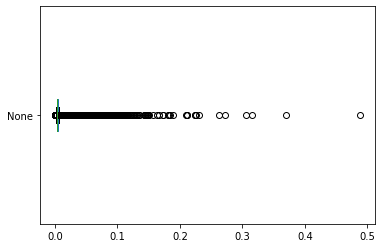

In [14]:
s_freq_per_pattern.plot.box(vert=False)

In [15]:
s_num_nodes_per_pattern = pd.Series(gow_miner.stat_num_nodes_per_pattern())
s_num_nodes_per_pattern.describe()

count    31682.000000
mean         6.110031
std          1.452774
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max          9.000000
dtype: float64

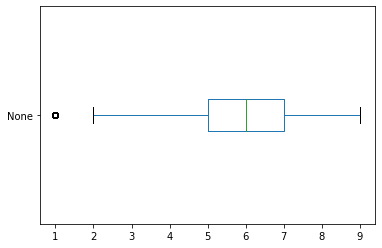

In [16]:
s_num_nodes_per_pattern.plot.box(vert=False)

## GoW Vectorizer Example

In [17]:
vectorizer_gow = GoWVectorizer(gow_miner, indexing=True, min_df=0.0, max_df=1.0)

In [18]:
X = vectorizer_gow.fit_transform(X_train)

In [19]:
X

<5485x31682 sparse matrix of type '<class 'numpy.int64'>'
	with 1641028 stored elements in Compressed Sparse Row format>

In [20]:
print(X_train[1])

comput termin system cpml complet sale comput termin system inc complet sale share common stock and warrant acquir addit mln share sedio lugano switzerland for dlr compani warrant exercis for year purchas price dlr per share comput termin sedio bui addit share and increas total hold pct comput termin outstand common stock circumst involv chang control compani compani condit occur warrant exercis price equal pct common stock market price time not exce dlr per share comput termin sold technolgi right dot matrix impact technolog includ futur improv woodco inc houston tex for dlr continu exclus worldwid license technolog for woodco compani move part reorgan plan and pai current oper cost and ensur product deliveri comput termin make comput gener label form tag and ticket printer and termin reuter


In [21]:
feature_names = vectorizer_gow.get_feature_names()

In [22]:
features = [feature for presence, feature in zip(X.toarray()[1], feature_names) if presence > 0]
print("Nombre de features: {}".format(len(features)))
for feature in features:
    print(feature)

Nombre de features: 61
compani
comput
product and product__and
share mln share__mln
bui
purchas
per
pct
common stock stock__common
move
cost
futur
sale
acquir
dlr
for
gener
for year for__year
mln
control
year dlr year__dlr
share
for dlr for__dlr
plan
outstand
hold
share per share__per
common
product
current
part
stock
reuter and reuter__and
increas and increas__and
market
pct total pct__total
price dlr dlr__price
make
not
share and share__and
oper
and cost and__cost
and
common share common__share
for compani for__compani
for price for__price
inc
reuter
pai
includ
chang
increas
year
time
share dlr share__dlr
price
continu
total
for share dlr share__dlr for__dlr
complet
system


## Classification Task with Frequent Subgraphs

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, f1_score

### Hyper-optimisation metrics

In [24]:
from sklearn.metrics import matthews_corrcoef, make_scorer
scorer_mcc = make_scorer(matthews_corrcoef)

### Hyperparameter search

**/!\** Hyperparameter search is a time-consuming and computation-intensive procedure

In [25]:
from gowpy.feature_extraction.gow.gow_vectorizer import SUBGRAPH_MATCHING_INDUCED, SUBGRAPH_MATCHING_PARTIAL

In [ ]:
print('')
print("## GoW Model ##")
pipeline = Pipeline([
    ('gow', GoWVectorizer(gow_miner)),
    ('tfidf', TfidfTransformer()),
    ('svm', LinearSVC()),
])

parameters = {
    'gow__subgraph_matching' : [SUBGRAPH_MATCHING_INDUCED],
    'gow__indexing' : [True],
#
# min          0.000729
# 25%          0.003464
# 50%          0.003646
# 75%          0.004558
# max          0.487694
    'gow__min_df' : [0.0, 0.003464],
    'gow__max_df' : [0.5],
#
    'svm__C' : [0.1, 1, 10, 100],
    'svm__class_weight' : ['balanced'],
}

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           cv=10,
                           scoring=scorer_mcc,
                           n_jobs=-1, verbose=10)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Fitting the final model

In [26]:
param_C = 1
param_class_weight = 'balanced'

pipeline_gow = Pipeline([
    ('vect', GoWVectorizer(gow_miner, 
                           min_df=0.0,
                           max_df=1.0,
                           subgraph_matching='induced',
                           indexing=True
                          )),
    ('tfid', TfidfTransformer()),
    ('svm', LinearSVC(
        C=param_C,
        class_weight=param_class_weight,
    )),
])

pipeline_gow.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 GoWVectorizer(graph_of_words=Graph-of-word miner:
        - is_directed: False
        - is_weighted: False
        - window_size: 4
        - edge_labeling: True

        - Number of tokens: 14575
        - Number of links between tokens: 376354

        - Number of loaded subgraph: 31682
        ,
                               subgraph_matching='induced')),
                ('tfid', TfidfTransformer()),
                ('svm', LinearSVC(C=1, class_weight='balanced'))])

### Evaluation on the test

In [27]:
print('')
print('Results on the test set:')

y_pred = pipeline_gow.predict(X_test)
y_true = y_test
    
print(classification_report(y_true, y_pred))

mcc = matthews_corrcoef(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='micro')
print(f"mcc={mcc} ; accuracy={accuracy} ; f1-micro={f1}")


Results on the test set:
              precision    recall  f1-score   support

         acq       0.97      0.97      0.97       696
       crude       0.94      0.95      0.95       121
        earn       0.99      0.99      0.99      1083
       grain       1.00      1.00      1.00        10
    interest       0.86      0.78      0.82        81
    money-fx       0.80      0.83      0.81        87
        ship       0.85      0.92      0.88        36
       trade       0.92      0.97      0.95        75

    accuracy                           0.96      2189
   macro avg       0.92      0.93      0.92      2189
weighted avg       0.96      0.96      0.96      2189

mcc=0.9442491118465957 ; accuracy=0.9639104613978986 ; f1-micro=0.9639104613978986
